## Imports

In [1]:
import data
# data handling
import pandas as pd
import numpy as np
# machine learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Masking
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
# plotting
import matplotlib.pyplot as plt
import seaborn as sns
from hist import Hist
import hist
from matplotlib.patches import Rectangle
#other
import pickle
import time

In [11]:
waveform_data=pd.read_parquet('../../../Data/padded_waveforms.parquet')

## Plotting le waveforms 

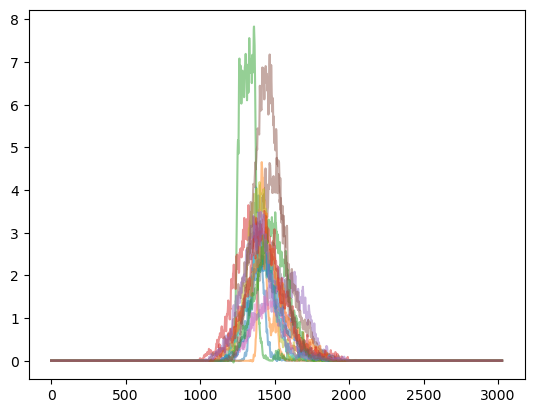

In [17]:
sample_waveforms=waveform_data['chonkers'].to_numpy()[100::500]
for waveform in sample_waveforms:
    plt.plot(waveform, alpha=0.5)

## Testing cropping 

In [80]:
cropped_data=['chonkers']
crop_value=100
while crop_value <= 1400:
    data.crop_waveforms(waveform_data,crop_value,'chonkers','front')
    data.crop_waveforms(waveform_data,crop_value,'chonkers','back')
    cropped_data.append('{}_front'.format(crop_value))
    cropped_data.append('{}_back'.format(crop_value))
    crop_value+=100
    

16


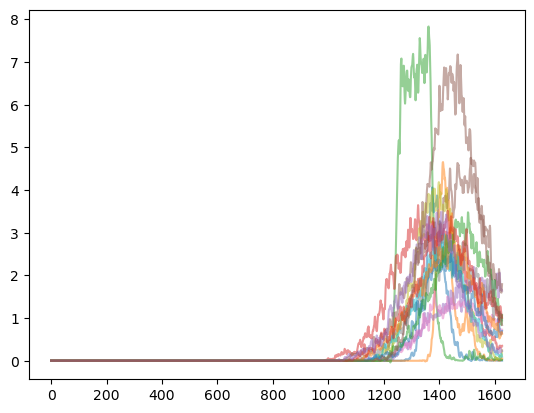

In [53]:
sample_waveforms=waveform_data['1400_back'].to_numpy()[100::500]
for waveform in sample_waveforms:
    plt.plot(waveform, alpha=0.5)

# cropping more off the back to see where accuracy decreases 
cropped_data2=[]
crop_value2=50
while crop_value2 <= 250:
    data.crop_waveforms(waveform_data,crop_value2,'1400_back','back')
    cropped_data2.append('{}_back'.format(crop_value2))
    crop_value2+=50

In [82]:
#ML_data={name:data.make_ML_data(waveform_data,name) for name in cropped_data}
ML_data2={name:data.make_ML_data(waveform_data,name) for name in cropped_data2}

results_dict={'accuracy':[],'execution_time':[]}
for crop in cropped_data2:
    
    X_train, X_test, \
    y_train, y_test, \
    W_train, W_test, \
    runID_train, runID_test, \
    eventID_train, eventID_test = ML_data2[crop]['data']
    
    CNN_model = keras.Sequential([
    keras.layers.Conv1D(filters=6,kernel_size=900,activation='relu', input_shape=(ML_data2[crop]['input_length'], 1)),
    keras.layers.Flatten(),
    keras.layers.Dense(3, activation='softmax')
    ])
    
    CNN_model.compile(optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
    weighted_metrics=['accuracy'])
    
    st=time.time()
    hist_CNN_model = CNN_model.fit(X_train,y_train,epochs=20, validation_split=0.2, shuffle=True, sample_weight=W_train)
    et=time.time()
    
    results_dict['accuracy'].append(CNN_model.evaluate(X_test,y_test, sample_weight=W_test)) 
    results_dict['execution_time'].append(et-st)
   # with open('cropping_testing/CNN01/{}{}'.format(crop,'.pkl'),'wb') as f:
   #         pickle.dump(CNN_model, f)
    results=pd.DataFrame(results_dict)
    results.to_parquet('cropping_testing/CNN01/more_results.parquet')
    print(crop)

In [61]:
#this is ugly but I cba to fix it
padding=np.arange(-800,700,100)
padding2=list(np.arange(-1050,-800,50))+list(padding)
results_df=pd.read_csv('cropping_testing/CNN01/results.csv',index_col=0)
results_df2=pd.read_parquet('cropping_testing/CNN01/more_results.parquet')
accuracies=[float(acc.strip('[]').split(', ')[2]) for acc in results_df['accuracy']] 
accuracies2=[list(acc)[2] for acc in results_df2['accuracy']]

back_accuracies=accuracies2[::-1]+accuracies[::2][::-1]
back_timesteps=results_df2['execution_time'].to_list()[::-1]+results_df['execution_time'].to_list()[::2][::-1]

front_accuracies=accuracies[1::2][::-1]+[accuracies[0]]
front_timesteps=results_df['execution_time'].to_list()[1::2][::-1]+[results_df['execution_time'][0]]

Text(0, 0.5, 'Execution Time/s')

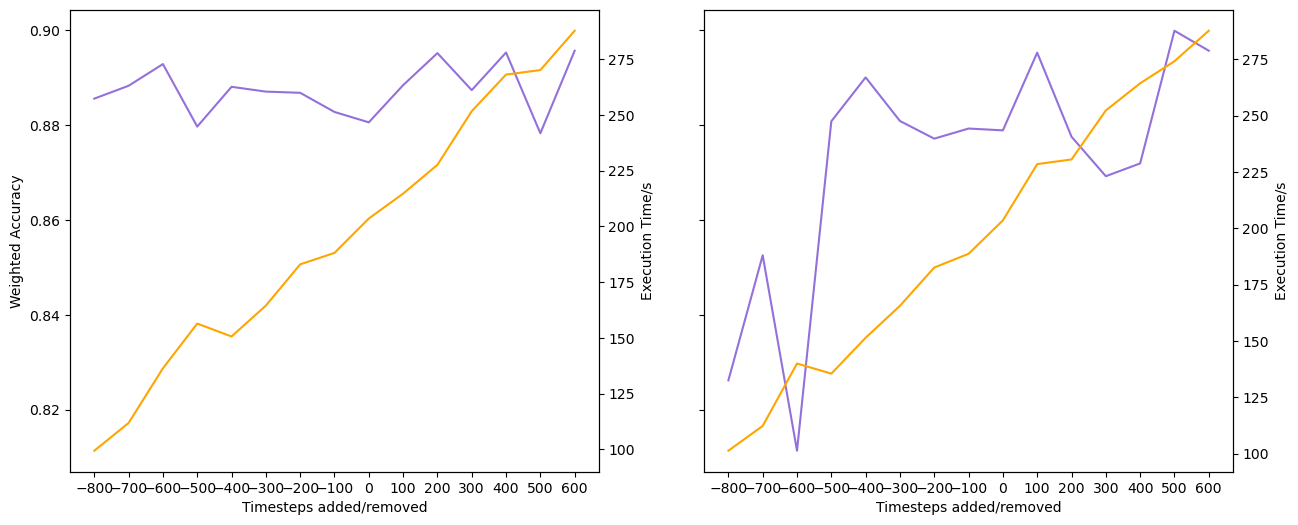

In [42]:
fig,ax=plt.subplots(1,2,figsize=(15,6),sharey=True)

ax[0].plot(padding,accuracies[::2][::-1],color='mediumpurple',label='Weighted Accuracy')
ax[0].set_xlabel('Timesteps added/removed')
ax[0].set_xticks(padding)
ax[0].set_ylabel('Weighted Accuracy')
#ax[0].grid()
#ax[0].set_ylim(top=1.00)
#ax[0].legend()

ax1=ax[0].twinx()
ax1.plot(padding,results_df['execution_time'].to_numpy()[::2][::-1],color='orange',label='Execution Time')
ax1.set_xlabel('Timesteps added/removed')
ax1.set_xticks(padding)
ax1.set_ylabel('Execution Time/s')
#ax1.legend()

ax[1].plot(padding,accuracies[1::2][::-1]+[accuracies[0]],color='mediumpurple')
ax[1].set_xlabel('Timesteps added/removed')
ax[1].set_xticks(padding)
# ax[1].grid()
# ax[1].set_ylabel('Weighted Accuracy')
# ax[1].set_ylim(top=1.0)

ax2=ax[1].twinx()
ax2.plot(padding,list(results_df['execution_time'].to_numpy()[1::2][::-1])+[results_df['execution_time'].to_numpy()[0]],color='orange')
ax2.set_xlabel('Timesteps added/removed')
ax2.set_xticks(padding)
ax2.set_ylabel('Execution Time/s')

## Finding percentiles

For the back of the pulse plot, I think it would be nice to see:
- The average ends of pulses (solid vertical line) as well as the 10th-90th percentiles (transparent rectangle)
- The average aft_75 (solid vertical line) as well as the 10th-90th percentiles (transparent rectangle)

For the front of the pulse plot, I think it would be nice to see:
- The average beginning of pulses (solid vertical line) as well as the 10th-90th percentiles (transparent rectangle)
- The average aft_5o (solid vertical line) as well as the 10th-90th percentiles (transparent rectangle)

In terms of timesteps removed this is average number of steps removed to get to each point 

Need to calculate: 
- Average pulse length & percentiles 
- aft values for all pulses using numerical integration 

In [4]:
# Pulse length stats 
lengths=waveform_data['length'].to_numpy()
len_10,len_90=np.percentile(lengths,[10,90])
len_mean=np.mean(lengths)
len_mean,len_10,len_90

(771.5612952968388, 518.0, 995.0)

In [5]:
mean_padding=(max(lengths)-len_mean)/2
padding_10=(max(lengths)-len_10)/2
padding_90=(max(lengths)-len_90)/2
padding_10,padding_90

(655.0, 416.5)

In [36]:
# hist=plt.hist(lengths, bins=100)
# plt.vlines(len_mean,0,320, color='black')
# plt.vlines(len_90,0,320, color='black')
# plt.vlines(len_10,0,320, color='black')

calculating aft - need to 'integrate' all the pulses and find the proportions 

points are evenly spaced so 'time' axis is just a scaling factor - can add up all arrays and find point at which they reach required %

doing this in data.py module

In [15]:
# calculating afts for all waveforms

waveform_data['aft75'] = [data.calc_aft(wav,0.75) for wav in waveform_data['samples']]
waveform_data['aft5'] = [data.calc_aft(wav,0.05) for wav in waveform_data['samples']]

In [20]:
# finding number position of aft75 from back 
waveform_data['aft75_pos'] = waveform_data.apply(lambda row: row.length - row.aft75, axis=1)

In [21]:
# aft stats 

aft75=waveform_data['aft75_pos'].to_numpy()
aft75_10,aft75_90=np.percentile(aft75,[10,90])
aft75_mean=np.mean(aft75)


aft5=waveform_data['aft5'].to_numpy()
aft5_10,aft5_90=np.percentile(aft5,[10,90])
aft5_mean=np.mean(aft5)

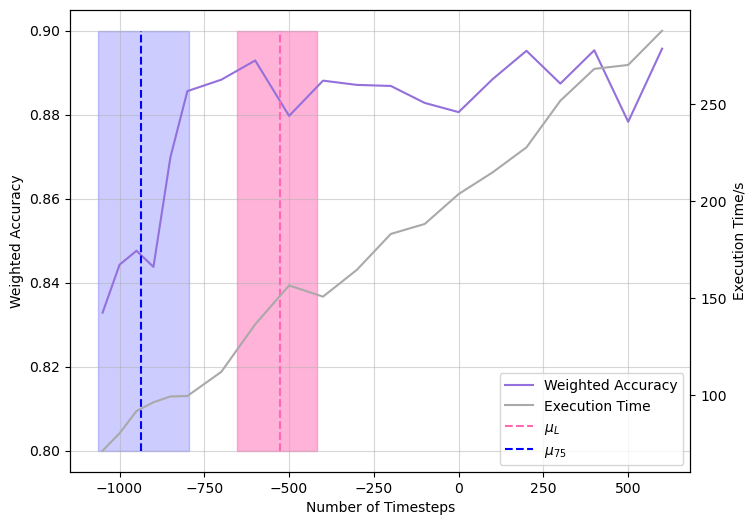

In [69]:
fig,ax=plt.subplots(1,1,figsize=(8,6),sharey=True)

ends_rec=Rectangle((-padding_10,0.8),padding_10-padding_90, 0.1,color='hotpink',alpha=0.5)
aft75_rec=Rectangle((-aft75_10-mean_padding,0.8),aft75_10-aft75_90, 0.1,color='blue',alpha=0.2)

ax.add_patch(ends_rec)
ax.add_patch(aft75_rec)
ax.plot(padding2,back_accuracies,color='mediumpurple',label='Weighted Accuracy')
ax.plot(padding2[0],back_accuracies[0],color='darkgrey',label='Execution Time')
ax.vlines(-mean_padding,0.8,0.9, color='hotpink',ls='--',label=r'$\mu_L$')
ax.vlines(-mean_padding-aft75_mean,0.8,0.9, color='blue',ls='--',label=r'$\mu_{75}$')

ax1=ax.twinx()
ax1.plot(padding2,back_timesteps,color='darkgray',label='Execution Time')
ax1.set_ylabel('Execution Time/s')

ax.set_xlabel('Number of Timesteps')
ax.set_ylabel('Weighted Accuracy')

ax.grid(alpha=0.5)
ax.legend()



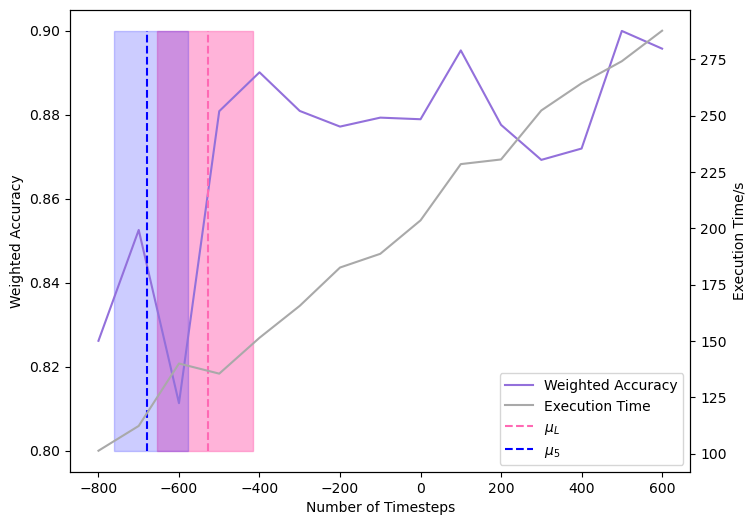

In [71]:
fig,ax=plt.subplots(1,1,figsize=(8,6),sharey=True)

ends_rec=Rectangle((-padding_10,0.8),padding_10-padding_90, 0.1,color='hotpink',alpha=0.5)
aft5_rec=Rectangle((-aft5_10-mean_padding,0.8),aft5_10-aft5_90, 0.1,color='blue',alpha=0.2)

ax.add_patch(ends_rec)
ax.add_patch(aft5_rec)
ax.plot(padding,front_accuracies,color='mediumpurple',label='Weighted Accuracy')
ax.plot(padding[0],front_accuracies[0],color='darkgrey',label='Execution Time')
ax.vlines(-mean_padding,0.8,0.9, color='hotpink',ls='--',label=r'$\mu_L$')
ax.vlines(-mean_padding-aft5_mean,0.8,0.9, color='blue',ls='--',label=r'$\mu_{5}$')

ax1=ax.twinx()
ax1.plot(padding,front_timesteps,color='darkgray',label='Execution Time')
ax1.set_ylabel('Execution Time/s')

ax.set_xlabel('Number of Timesteps')
ax.set_ylabel('Weighted Accuracy')

#ax.grid(alpha=0.5)
ax.legend()